<a href="https://colab.research.google.com/github/naye971012/2023_sanhak_ML_study/blob/main/2023%EC%82%B0%ED%95%99_5%EC%9B%94_4%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5/VIT_MNIST_LI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/daewoung/Vision-Transformer-MNIST-Pytorch-Lightning/blob/main/VIT_MNIST_LI.ipynb -> 여기서 가져왔습니다다

#import module

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 1.5 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import matplotlib.pyplot as plt
import pytorch_lightning as pl
torch.manual_seed(0)

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.6 MB/s eta 0:00:00


In [ ]:
from einops.layers.torch import Reduce

#load data

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataset, val_dataset = random_split(training_data, [55000, 5000])

learning_rate = 1e-3
batch_size = 128
epochs = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
import numpy as np

In [ ]:
data, label = next(iter(train_dataloader))

In [ ]:
data.shape #[batch_size, channel, width, height]

torch.Size([128, 1, 28, 28])

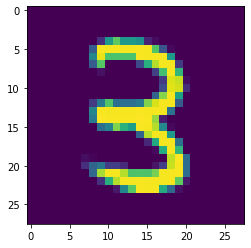

In [ ]:
plt.imshow(data[0].reshape(28,28))

In [ ]:
label

tensor([3, 0, 1, 4, 2, 4, 8, 4, 3, 3, 9, 0, 4, 7, 3, 9, 1, 8, 1, 0, 0, 3, 3, 7,
        2, 0, 7, 8, 7, 6, 9, 8, 8, 1, 9, 9, 6, 5, 4, 1, 1, 5, 3, 1, 7, 2, 8, 7,
        1, 9, 9, 9, 6, 5, 3, 5, 6, 7, 5, 8, 4, 1, 6, 4, 4, 1, 7, 5, 9, 4, 3, 1,
        4, 4, 4, 7, 9, 8, 2, 1, 7, 7, 8, 8, 3, 0, 1, 5, 2, 2, 6, 2, 2, 2, 7, 8,
        3, 7, 8, 0, 6, 6, 1, 9, 5, 5, 0, 9, 1, 1, 0, 1, 0, 5, 0, 0, 6, 8, 3, 2,
        1, 9, 3, 8, 9, 3, 9, 9])

In [ ]:
data[0].shape

torch.Size([1, 28, 28])

In [ ]:
project = nn.Conv2d(1, 16, kernel_size= 4, stride=4)
#in_chan = 1
#self.emb_size = Channel * Patch Size * Patch Size = 1 * 4 * 4 = 16
#Kernel Size = Patch Size 
#Stride = Patch Size
project(data[0].unsqueeze(0)).shape

torch.Size([1, 16, 7, 7])

#model defining

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self,in_chan, img_size, patch_size,batch_size=128):
        super().__init__()
        self.num_patches = int(img_size / pow(patch_size, 2)) # 49
        self.emb_size = in_chan * patch_size * patch_size # 16
        self.project = nn.Conv2d(in_chan, self.emb_size, kernel_size= patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,self.emb_size))
        self.positions = nn.Parameter(torch.randn(self.num_patches+ 1, self.emb_size)) # [50,16]
    
 
    def forward(self, x):
        x = self.project(x)
        x = x.view(-1, 49, 16) # [batch_size, 49, 16]
        repeat_cls = self.cls_token.repeat(x.size()[0],1,1) #[batch_size, 1 , 16]
        x = torch.cat((repeat_cls, x), dim=1)
        x += self.positions
        return x

In [ ]:
class Multihead(nn.Module):
    def __init__(self, emb_size, num_heads):
        super().__init__()
        self.multiheadattention = nn.MultiheadAttention(emb_size, num_heads, batch_first = True, dropout=0.2)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attn_output, attention = self.multiheadattention(query, key, value)
        return attn_output, attention


In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.2):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )

In [ ]:
class VIT(nn.Module):
    def __init__(self,emb_size = 16):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(1, 28*28, 4)
        self.Multihead = Multihead(emb_size, 8)
        self.FFB = FeedForwardBlock(emb_size)
        self.norm = nn.LayerNorm(emb_size)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        
        norm_x = self.norm(x)
        multihead_output, attention = self.Multihead(norm_x)
        
        #residual Function
        output = multihead_output + x
        
        norm_output = self.norm(output)
        FFB = self.FFB(norm_output)
        
        final_out = FFB + output
        
        return final_out, attention

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_layers: 5, ):
        super().__init__()
        self.layers = nn.ModuleList([VIT() for _ in range(n_layers)])
        
    def forward(self, x):
        for layer in self.layers:
            final_out, attention = layer(x)
            
        return final_out

In [ ]:
class VIT_Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.loss = []
        self.Encoder = nn.Sequential(
            TransformerEncoder(n_layers = 5),
            #Reduce('b n e -> b e', reduction='mean')
        )
        self.final_layer = nn.Linear(16, 10)
        self.val_loss = []
        self.acc = []
        self.test_acc =[]
        
    def forward(self, x):
        x = self.Encoder(x)
        cls_token_final = x[:,0]
        #(cls_token_final.shape)
        cls_token_final = self.final_layer(cls_token_final)
        return cls_token_final
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)

        self.loss.append(loss.item())
        return loss 
    
    def training_epoch_end(self, batch):
        mean_loss = sum(self.loss) / 430
        print(f'traing_loss :{mean_loss}')
        self.loss = []
        self.acc = []
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)
        self.val_loss.append(loss.item())
        acc = ac(logits, y)
        self.acc.append(acc)
        return loss 
    
    def validation_epoch_end(self, batch):
        mean_loss = sum(self.val_loss) / 40
        mean_acc = sum(self.acc)/ 40
        print(f'val loss :{mean_loss}, val_acc : {mean_acc}')

        self.val_loss = []
        self.acc = []
        self.log("val_loss", mean_loss)
        
    def test_dataloader(self):
        return test_dataloader
        
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = ac(logits, y)
        self.test_acc.append(acc)
        
    def test_epoch_end(self, batch):
        mean_acc = sum(self.test_acc)/ 79
        print(mean_acc)


            
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)              
        

#run model

In [ ]:
import torchmetrics
ac = torchmetrics.Accuracy(task="multiclass", num_classes = 10).to('cuda')

gpus = torch.cuda.device_count()
gpus

1

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_loss', mode ='min', patience=5)

In [ ]:
model = VIT_Encoder()
trainer = pl.Trainer(max_epochs=10, gpus=gpus, callbacks=[early_stop_callback])
trainer.fit(model, train_dataloader, val_dataloaders = val_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | Encoder     | Sequential | 25.8 K
1 | final_layer | Linear     | 170   
-------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val loss :0.13639219403266906, val_acc : 0.0044921874068677425


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val loss :0.6404739134013653, val_acc : 0.7914062738418579
traing_loss :1.5459579237671786


Validation: 0it [00:00, ?it/s]

val loss :0.42762366160750387, val_acc : 0.865429699420929
traing_loss :0.6148818650911021


Validation: 0it [00:00, ?it/s]

val loss :0.370085171982646, val_acc : 0.8832031488418579
traing_loss :0.5059924723103989


In [ ]:
k = model.test_dataloader()
b, y = next(iter(k))
print(y.shape)

torch.Size([128])


In [ ]:
trainer.test()

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_3/checkpoints/epoch=2-step=1290.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/lightning_logs/version_3/checkpoints/epoch=2-step=1290.ckpt


Testing: 0it [00:00, ?it/s]

tensor(0.8946, device='cuda:0')


[{}]

#model structure

In [ ]:
model

VIT_Encoder(
  (Encoder): Sequential(
    (0): TransformerEncoder(
      (layers): ModuleList(
        (0): VIT(
          (embedding_layer): EmbeddingLayer(
            (project): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
          )
          (Multihead): Multihead(
            (multiheadattention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
            )
            (query): Linear(in_features=16, out_features=16, bias=True)
            (key): Linear(in_features=16, out_features=16, bias=True)
            (value): Linear(in_features=16, out_features=16, bias=True)
          )
          (FFB): FeedForwardBlock(
            (0): Linear(in_features=16, out_features=64, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.2, inplace=False)
            (3): Linear(in_features=64, out_features=16, bias=True)
          )
          (norm): LayerNorm((16,), eps=1e-05, elementwis

In [ ]:
VIT()

VIT(
  (embedding_layer): EmbeddingLayer(
    (project): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
  )
  (Multihead): Multihead(
    (multiheadattention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (query): Linear(in_features=16, out_features=16, bias=True)
    (key): Linear(in_features=16, out_features=16, bias=True)
    (value): Linear(in_features=16, out_features=16, bias=True)
  )
  (FFB): FeedForwardBlock(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
  )
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
)